In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
N = 101
x = np.sort(np.random.uniform(0, 10, N))
tau = x[:, None] - x[None, :]
K = np.exp(-0.5 * tau**2) * np.cos(2*np.pi*np.abs(tau))
K[np.diag_indices_from(K)] += 0.1
# K = K[:N//2, N//2:]

In [41]:
def low_rank_approx(K,
                    start_row=0, n_rows=None,
                    start_col=0, n_cols=None,
                    tol=1.234e-5, max_rank=None,
                    random=None):
    if random is None:
        random = np.random.RandomState()
    
    n_rows = K.shape[0] - start_row if n_rows is None else n_rows
    n_cols = K.shape[1] - start_col if n_cols is None else n_cols
    if max_rank is None:
        max_rank = min(n_rows, n_cols)
    U = np.empty((n_rows, max_rank))
    V = np.empty((n_cols, max_rank))

    rank = 0
    index = np.arange(n_rows)
    norm = 0.0
    finished = False
    rows = slice(start_row, start_row+n_rows)
    cols = slice(start_col, start_col+n_cols)
    
    while True:
        while True:
            if not len(index):
                finished = True
                break
            k = random.randint(len(index))
            i = index[k]
            index[k] = index[-1]
            index = index[:-1]
            
            row = (K[start_row+i, cols] -
                   np.dot(U[i, :rank], V[:, :rank].T))
            j = np.argmax(np.abs(row))
            if np.abs(row[j]) > 1e-14:
                break
                        
        if finished:
            if not rank:
                print("failed")
                if n_cols <= n_rows:
                    return K[rows, cols], np.eye(n_cols)
                return np.eye(n_rows), K[rows, cols].T
            break
        
        row /= row[j]
        V[:, rank] = row
        
        U[:, rank] = col = (K[rows, start_col+j] -
                            np.dot(U[:, :rank], V[j, :rank]))
        
        rank += 1
        if rank >= max_rank:
            break
    
        rowcol_norm = np.dot(row, row) * np.dot(col, col)
        if rowcol_norm < tol**2 * norm:
            break
        
        norm += rowcol_norm
        s = np.dot(U[:, :rank-1].T, col)
        norm += 2 * np.sum(np.abs(s))
        s = np.dot(V[:, :rank-1].T, row)
        norm += 2 * np.sum(np.abs(s))
    
    return U[:, :rank], V[:, :rank]

U, V = low_rank_approx(K, N//2, N-N//2, 0, N//2)

In [5]:
U.shape, V.shape, K[N//2:, :N//2].shape

((51, 17), (50, 17), (51, 50))

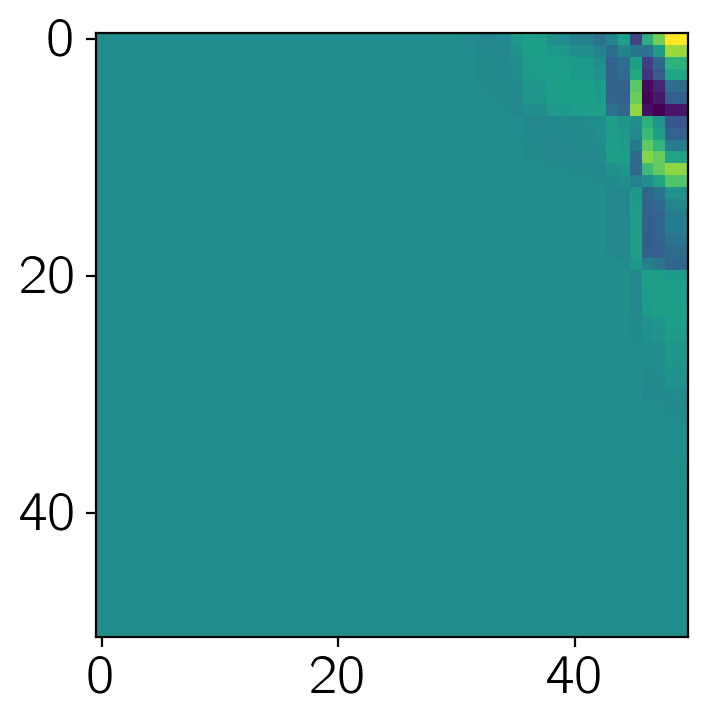

In [6]:
plt.imshow(K[N//2:, :N//2], interpolation="nearest")

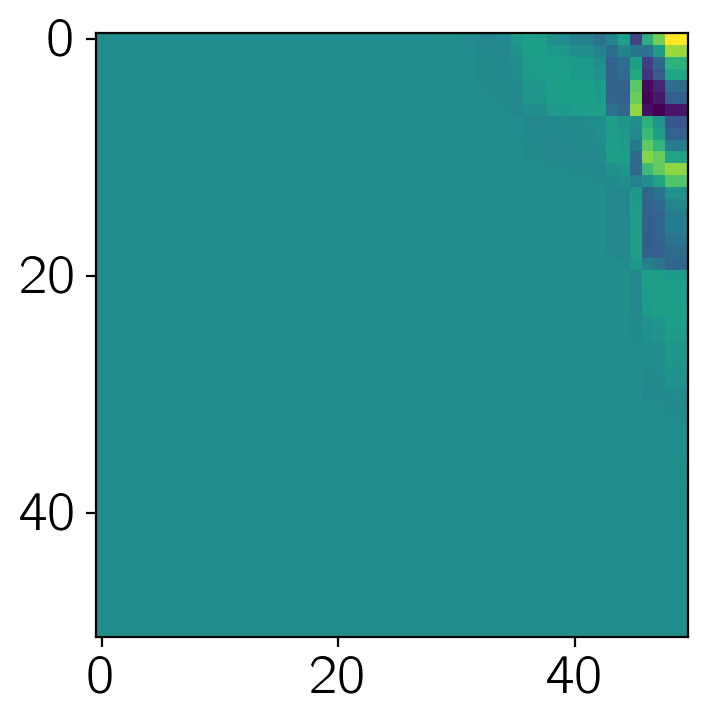

In [7]:
plt.imshow(np.dot(U, V.T), interpolation="nearest")

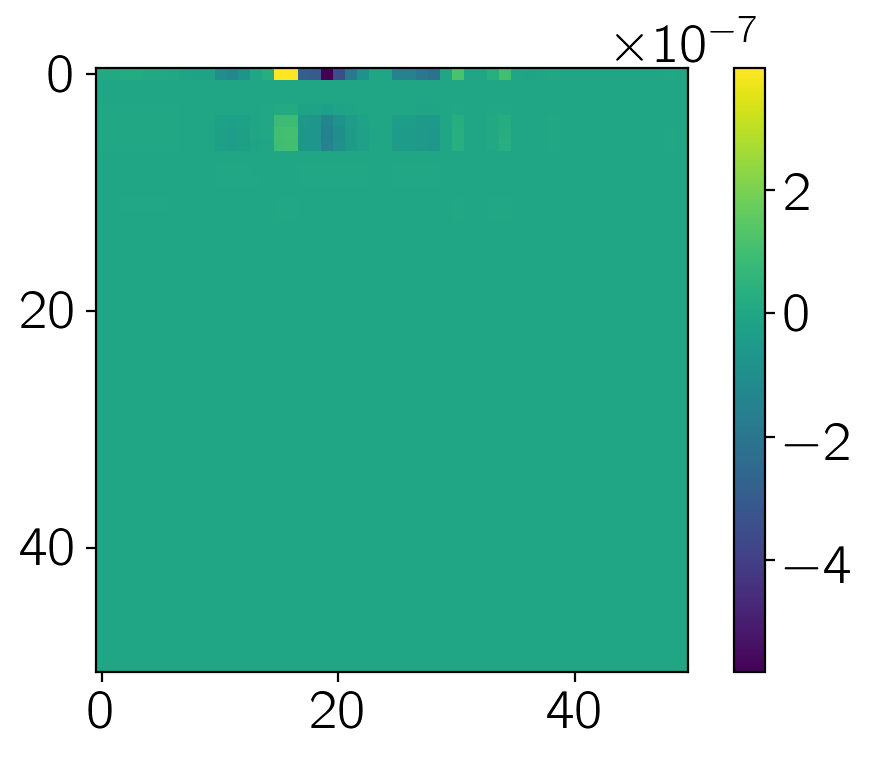

In [8]:
plt.imshow((K[N//2:, :N//2] - np.dot(U, V.T)), interpolation="nearest")
plt.colorbar()

In [433]:
from scipy.linalg import lu_factor, lu_solve

class Node(object):
    
    def __init__(self,
                 K,               # The matrix
                 start=0,         # The starting index of this node
                 size=None,       # The width of the node
                 tol=1.234e-5,    # Tolerance for approximation
                 min_size=100,    # Minimum leaf width
                 left=None,       # Flag indicating direction of branch
                 parent=None,     # The parent node
                 random=None      # A random number generator
                ):
        self.left = left
        self.parent = parent
        size = K.shape[0] if size is None else size
        self.start = start
        self.size = size
        if size // 2 >= min_size:
            self.U = [None, None]
            self.V = [None, None]
            self.U[1], self.V[0] = low_rank_approx(
                K,
                start_row=start+size//2,
                n_rows=size-size//2,
                start_col=start,
                n_cols=size//2,
                tol=tol, random=random)
            
            # Make copies for applying the inverses of children
            self.U[0] = np.array(self.V[0])
            self.V[1] = np.array(self.U[1])
            self.rank = self.U[0].shape[1]

            self.is_leaf = False
            self.children = (
                Node(K, start, size//2,
                     tol, min_size, random=random,
                     parent=self, left=True),
                Node(K, start+size//2, size-size//2,
                     tol, min_size, random=random,
                     parent=self, left=False),
            )
            
        else:
            self.is_leaf = True
            self.children = tuple()
            self.S = np.array(K[start:start+size, start:start+size])
            
    def compute(self):
        for child in self.children:
            child.compute()
        self.compute_S()
        node = self.parent
        start = self.start
        ind = 0 if self.left else 1
        while node is not None:
            node.U[ind] = self._apply_inverse(node.U[ind], start)
            start = node.start
            ind = 0 if node.left else 1
            node = node.parent
    
    def compute_S(self):
        if not self.is_leaf:
            rank = self.rank
            self.S = np.eye(2*rank)
            self.S[:rank, rank:] = np.dot(self.V[1].T, self.U[1])
            self.S[rank:, :rank] = np.dot(self.V[0].T, self.U[0])

        self.S = lu_factor(self.S, overwrite_a=True)
    
    def __repr__(self):
        return ("Node({0.start}, {0.size})").format(self)
    
    def _apply_inverse(self, x, start):
        start = self.start - start
        if self.is_leaf:
            x[start:start+self.size] = lu_solve(self.S, x[start:start+self.size], overwrite_b=True)
            return x
    
        shape = list(x.shape)
        shape[0] = 2*self.rank
        temp = np.empty(shape)
        s1 = self.children[0].size
        s2 = self.children[1].size

        temp[:self.rank] = np.dot(self.V[1].T, x[start+s1:start+s1+s2])
        temp[self.rank:] = np.dot(self.V[0].T, x[start:start+s1])
        temp = lu_solve(self.S, temp, overwrite_b=True)

        x[start:start+s1] -= np.dot(self.U[0], temp[:self.rank])
        x[start+s1:start+s1+s2] -= np.dot(self.U[1], temp[self.rank:])
        return x
    
    def apply_inverse(self, x):
        for child in self.children:
            x = child.apply_inverse(x)
        return self._apply_inverse(x, 0)
        
    def log_determinant(self):
        logdet = np.sum(np.log(np.abs(np.diag(self.S[0]))))
        for child in self.children:
            logdet += child.log_determinant()
        return logdet

In [447]:
random = np.random.RandomState(42)
root = Node(K, random=random, min_size=5)
root.compute()

In [453]:
root.children[0].children

(Node(0, 25), Node(25, 25))

In [449]:
root.log_determinant(), np.linalg.slogdet(K)[1]

(-165.30233035504668, -165.3023383604226)

In [450]:
x0 = np.random.randn(N, 5)

In [451]:
x = np.array(x0)
root.apply_inverse(x) - np.linalg.solve(K, x0)

array([[ -1.78608359e-06,  -3.27255662e-06,   1.24005590e-05,
          2.20071992e-07,   6.64210257e-06],
       [ -1.57363594e-05,  -1.10600048e-05,  -2.58190304e-05,
          6.53466572e-06,  -2.42662167e-05],
       [ -1.39367082e-05,  -9.12023448e-06,  -4.12748314e-05,
          7.02454800e-06,  -3.18533311e-05],
       [ -9.86236281e-06,  -8.27448694e-06,  -2.69307123e-05,
          1.57924312e-06,  -1.92856083e-05],
       [  8.29791446e-06,   7.64493485e-07,   1.91371415e-05,
         -6.67502317e-06,   1.92562417e-05],
       [  1.36779326e-05,   4.58143211e-06,   2.88335966e-05,
         -5.32764574e-06,   2.67338361e-05],
       [  1.88581488e-05,   8.93897989e-06,   3.63039512e-05,
         -1.81965036e-06,   3.18880901e-05],
       [  1.06177061e-05,   4.05441309e-06,   2.59217741e-05,
         -1.25362217e-06,   2.19066180e-05],
       [ -9.72044926e-07,  -5.66840206e-06,   1.55273507e-05,
         -9.25543623e-06,   1.39564488e-05],
       [ -2.85433315e-06,  -7.2919244

In [452]:
np.linalg.solve(K, x0)

array([[ -1.49098277e+01,   7.65754720e+00,   1.25192136e+01,
          7.64545796e-01,   1.22362483e+01],
       [  1.73264167e+01,  -3.12039006e+00,  -2.00608811e+01,
         -6.00275288e+00,  -1.16559814e+01],
       [ -9.80813225e+00,  -1.20992008e+01,  -1.82160047e+00,
         -1.67143469e+00,   2.21550800e+01],
       [  1.77431158e+00,  -4.62247065e+00,   3.13637007e+00,
         -2.01924526e+00,  -8.23517286e+00],
       [  1.60298306e+01,   5.00124204e+00,   1.33704046e+01,
          1.10980256e+01,  -4.20627993e+00],
       [ -3.82900075e+00,   2.77115547e+00,   1.02196022e-02,
          1.06011391e+01,  -7.80628323e+00],
       [ -6.23062510e+00,  -1.63690047e+01,   2.74999510e+00,
          2.26600579e+00,   3.05889135e+00],
       [  6.92416062e+00,   1.58740771e+01,   2.84550091e+00,
          4.29720667e+00,   8.72652502e-02],
       [ -1.52389091e+01,   2.77249883e+00,  -2.56473498e+01,
         -8.15763323e+00,  -4.04124341e+00],
       [ -5.24129621e-01,   1.0258143

In [291]:
root.V[0][0]

array([ -3.37478176e-14,   1.94577600e-11,  -7.24225978e-09,
        -3.00535730e-10,   2.35734213e-07,   7.01111040e-07,
         1.26845259e-06,  -2.38237772e-06,   1.65330121e-05,
         8.30605143e-06,   1.24076079e-05,  -2.13668341e-04,
         2.07632691e-05,   2.57517049e-04,   2.94201801e-03,
         3.63567685e-03,   4.54317683e-04])

In [90]:
root.compute_K()

In [91]:
np.linalg.slogdet(K)

(1.0, -165.3023383604226)

In [15]:
root.children[0].children[0].children[0].children[0].log_determinant()

-6.8880219216076322

In [331]:
np.sum(np.log(np.abs(np.diag(lu_factor(K)[0]))))

-163.67731577167658

In [332]:
np.linalg.slogdet(K)

(1.0, -163.67731577167658)